In [1]:
import torch
from torchvision import datasets
from torch import optim
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import requests

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
train= pd.read_csv("train.csv")

In [4]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
train.shape


(200000, 202)

In [6]:
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [7]:
train['target'].value_counts(normalize=True)


target
0    0.89951
1    0.10049
Name: proportion, dtype: float64

In [8]:
X = train.drop(['ID_code','target'], axis=1)
y = train['target']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_imputed = imputer.transform(X_train)
X_val_imputed = imputer.transform(X_val)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_imputed)
X_val = scaler.transform(X_val_imputed)

x_train_tensor = torch.as_tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.as_tensor(y_train.values.reshape(-1,1), dtype=torch.float32)
x_val_tensor = torch.as_tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.as_tensor(y_val.values.reshape(-1,1), dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [9]:
print(f"NaNs in X_train: {np.isnan(X_train).any()}")
print(f"NaNs in X_val: {np.isnan(X_val).any()}")
print(y_train.min(), y_train.max())  # should be 0 and 1
print(y_val.min(), y_val.max())

NaNs in X_train: False
NaNs in X_val: False
0 1
0 1


In [10]:
# Replace NaNs in validation with training means
from sklearn.impute import SimpleImputer

# Create imputer fitted on training data
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)

# Transform both sets (this handles NaNs properly)
X_train_imputed = imputer.transform(X_train)
X_val_imputed = imputer.transform(X_val)

# Now scale with the clean data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

# Verify no NaNs remain
print("NaNs in X_train_scaled:", np.isnan(X_train_scaled).any())
print("NaNs in X_val_scaled:", np.isnan(X_val_scaled).any())

# Update your tensors
x_train_tensor = torch.as_tensor(X_train_scaled).float()
y_train_tensor = torch.as_tensor(y_train.values.reshape(-1,1)).float()
x_val_tensor = torch.as_tensor(X_val_scaled).float()
y_val_tensor = torch.as_tensor(y_val.values.reshape(-1,1)).float()

NaNs in X_train_scaled: False
NaNs in X_val_scaled: False


In [11]:
print(y_train.min(), y_train.max())
print(y_val.min(), y_val.max())

0 1
0 1


In [12]:
class ManualClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(200, 1)

    def forward(self, x):
        return self.fc1(x)  # raw logits


model = ManualClassification()
model.to(device)

ManualClassification(
  (fc1): Linear(in_features=200, out_features=1, bias=True)
)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()



In [14]:
def accuracy(outputs, targets):
    preds = (outputs > 0.5).float()
    return (preds == targets).sum().item() / targets.size(0)



Epoch 1/20 | Train Loss: 0.2583, Val Loss: 0.2458 | Train Acc: 0.9057, Val Acc: 0.9100
Epoch 2/20 | Train Loss: 0.2440, Val Loss: 0.2388 | Train Acc: 0.9103, Val Acc: 0.9131
Epoch 3/20 | Train Loss: 0.2377, Val Loss: 0.2335 | Train Acc: 0.9115, Val Acc: 0.9133
Epoch 4/20 | Train Loss: 0.2314, Val Loss: 0.2334 | Train Acc: 0.9131, Val Acc: 0.9137
Epoch 5/20 | Train Loss: 0.2264, Val Loss: 0.2338 | Train Acc: 0.9146, Val Acc: 0.9153
Epoch 6/20 | Train Loss: 0.2195, Val Loss: 0.2303 | Train Acc: 0.9161, Val Acc: 0.9143
Epoch 7/20 | Train Loss: 0.2153, Val Loss: 0.2309 | Train Acc: 0.9177, Val Acc: 0.9146
Epoch 8/20 | Train Loss: 0.2114, Val Loss: 0.2319 | Train Acc: 0.9189, Val Acc: 0.9141
Epoch 9/20 | Train Loss: 0.2068, Val Loss: 0.2317 | Train Acc: 0.9200, Val Acc: 0.9149
Epoch 10/20 | Train Loss: 0.2023, Val Loss: 0.2339 | Train Acc: 0.9214, Val Acc: 0.9138
Epoch 11/20 | Train Loss: 0.1989, Val Loss: 0.2362 | Train Acc: 0.9231, Val Acc: 0.9127
Epoch 12/20 | Train Loss: 0.1958, Val Los

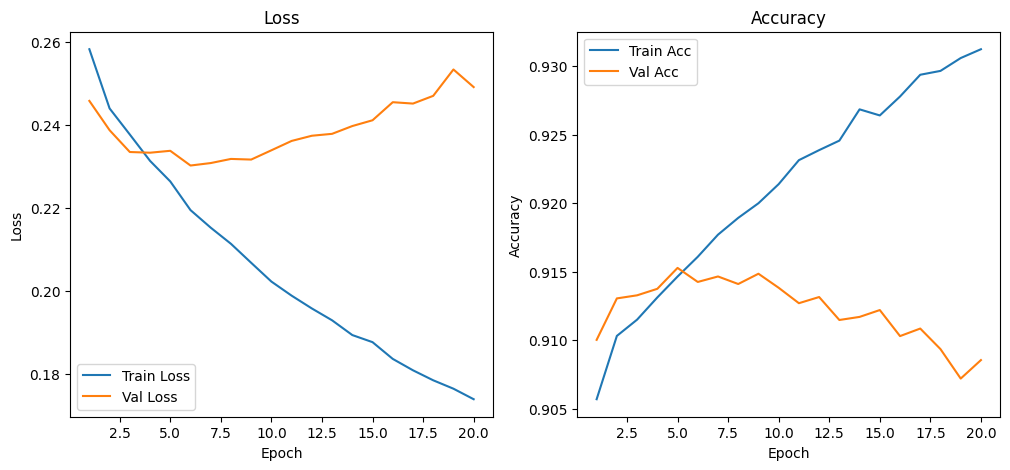

In [17]:
# --- Dataset & DataLoader ---
class SantanderDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Binary target
    def __getitem__(self, idx):
        return self.X[idx].to(device), self.y[idx].to(device)
    def __len__(self):
        return len(self.X)

train_dataset = SantanderDataset(X_train, y_train.values)
valid_dataset = SantanderDataset(X_val, y_val.values)


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# --- Model ---
model = nn.Sequential(
    nn.Linear(200, 1000),
    nn.BatchNorm1d(1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 1000),
    nn.BatchNorm1d(1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 1)  # Binary output
).to(device)

criterion = nn.BCEWithLogitsLoss()  # استفاده از BCEWithLogitsLoss امن تره
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Accuracy function
def accuracy(outputs, targets):
    preds = torch.sigmoid(outputs) > 0.5
    return (preds.float() == targets).sum().item() / targets.size(0)

# Train & Validate functions
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    total_acc = 0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)

def validate_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            total_acc += accuracy(outputs, targets)
    return total_loss / len(dataloader), total_acc / len(dataloader)

# ---Training loop---
n_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, criterion)
    val_loss, val_acc = validate_epoch(model, valid_dataloader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# --Plot---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,n_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1,n_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(range(1,n_epochs+1), train_accs, label='Train Acc')
plt.plot(range(1,n_epochs+1), val_accs, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy')
plt.show()


In [ ]:
print(np.isnan(X_train).any())
print(np.isnan(X_val).any())